In [1]:
%matplotlib inline



# Compute and visualize ERDS maps

This example calculates and displays ERDS maps of event-related EEG data.
ERDS (sometimes also written as ERD/ERS) is short for event-related
desynchronization (ERD) and event-related synchronization (ERS)
:footcite:`PfurtschellerLopesdaSilva1999`. Conceptually, ERD corresponds to a
decrease in power in a specific frequency band relative to a baseline.
Similarly, ERS corresponds to an increase in power. An ERDS map is a
time/frequency representation of ERD/ERS over a range of frequencies
:footcite:`GraimannEtAl2002`. ERDS maps are also known as ERSP (event-related
spectral perturbation) :footcite:`Makeig1993`.

In this example, we use an EEG BCI data set containing two different motor
imagery tasks (imagined hand and feet movement). Our goal is to generate ERDS
maps for each of the two tasks.

First, we load the data and create epochs of 5s length. The data set contains
multiple channels, but we will only consider C3, Cz, and C4. We compute maps
containing frequencies ranging from 2 to 35Hz. We map ERD to red color and ERS
to blue color, which is customary in many ERDS publications. Finally, we
perform cluster-based permutation tests to estimate significant ERDS values
(corrected for multiple comparisons within channels).


In [2]:
# Authors: Clemens Brunner <clemens.brunner@gmail.com>
#          Felix Klotzsche <klotzsche@cbs.mpg.de>
#
# License: BSD-3-Clause

As usual, we import everything we need.



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import matplotlib
from mne.channels import make_standard_montage
#matplotlib.use('Qt5Agg')

First, we load and preprocess the data. We use runs 6, 10, and 14 from
subject 1 (these runs contains hand and feet motor imagery).



In [18]:
runs = [3, 7, 11]  #Motor execution: left vs right hand
fnames = eegbci.load_data(subject=1, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']


In [19]:
#eegbci.standardize(raw)  # set channel names
#montage = make_standard_montage('standard_1005')
#raw.set_montage(montage)

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
#filtrar channles
raw.pick_channels(ch_names=['C3','Cz','C4','P3','Pz','P4','O1','O2'])

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



<RawEDF | S001R03.edf, 8 x 60000 (375.0 s), ~3.7 MB, data loaded>

Now we can create 5-second epochs around events of interest.



In [20]:
tmin, tmax = -1, 4
event_ids = dict(left=2, right=3)  # map event IDs to tasks


epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

Not setting metadata
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Loading data for 45 events and 961 original time points ...
0 bad epochs dropped



Here we set suitable values for computing ERDS maps. Note especially the
``cnorm`` variable, which sets up an *asymmetric* colormap where the middle
color is mapped to zero, even though zero is not the middle *value* of the
colormap range. This does two things: it ensures that zero values will be
plotted in white (given that below we select the ``RdBu`` colormap), and it
makes synchronization and desynchronization look equally prominent in the
plots, even though their extreme values are of different magnitudes.



In [21]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

Finally, we perform time/frequency decomposition over all epochs.



Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.717144
stat_fun(H1): min=-13.498739 max=3.436952
Running initial clustering
Found 50 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.717144
stat_fun(H1): min=-13.498739 max=3.436952
Running initial clustering
Found 107 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.717144
stat_fun(H1): min=-8.801536 max=3.727956
Running initial clustering
Found 64 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.717144
stat_fun(H1): min=-8.801536 max=3.727956
Running initial clustering
Found 79 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.717144
stat_fun(H1): min=-12.714926 max=3.685715
Running initial clustering
Found 31 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.717144
stat_fun(H1): min=-12.714926 max=3.685715
Running initial clustering
Found 112 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied


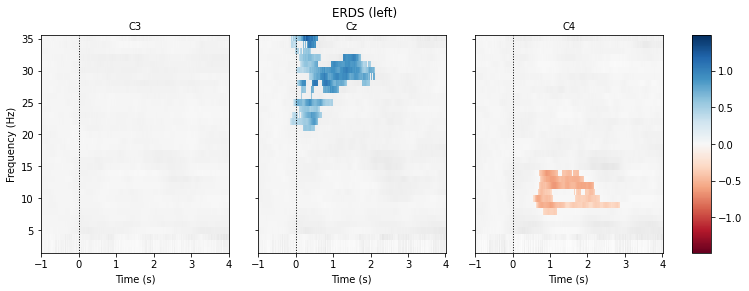

Using a threshold of 1.720743
stat_fun(H1): min=-7.713642 max=3.613706
Running initial clustering
Found 23 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.720743
stat_fun(H1): min=-7.713642 max=3.613706
Running initial clustering
Found 77 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.720743
stat_fun(H1): min=-6.001133 max=4.094128
Running initial clustering
Found 36 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.720743
stat_fun(H1): min=-6.001133 max=4.094128
Running initial clustering
Found 75 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.720743
stat_fun(H1): min=-10.825110 max=3.761877
Running initial clustering
Found 26 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.720743
stat_fun(H1): min=-10.825110 max=3.761877
Running initial clustering
Found 86 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied


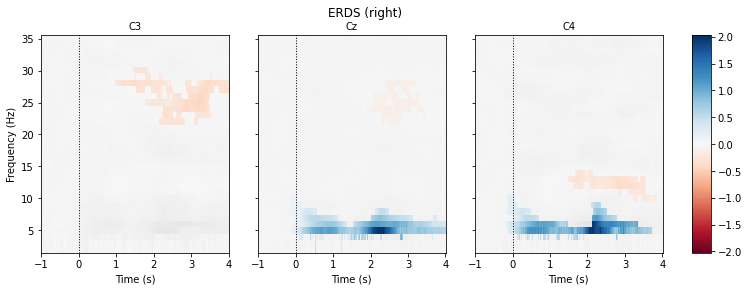

In [22]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Similar to `~mne.Epochs` objects, we can also export data from
`~mne.time_frequency.EpochsTFR` and `~mne.time_frequency.AverageTFR` objects
to a :class:`Pandas DataFrame <pandas.DataFrame>`. By default, the `time`
column of the exported data frame is in milliseconds. Here, to be consistent
with the time-frequency plots, we want to keep it in seconds, which we can
achieve by setting ``time_format=None``:



In [23]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C3,Cz,C4
0,-1.0000,2.0,0,right,-0.094142,-0.658951,-0.607765
1,-0.9875,2.0,0,right,-0.834483,-0.840122,-0.881397
2,-0.9750,2.0,0,right,-0.977717,-0.708101,-0.779627
3,-0.9625,2.0,0,right,-0.884696,-0.904119,-0.900701
4,-0.9500,2.0,0,right,-0.823192,-0.574829,-0.732676


This allows us to use additional plotting functions like
:func:`seaborn.lineplot` to plot confidence bands:



Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


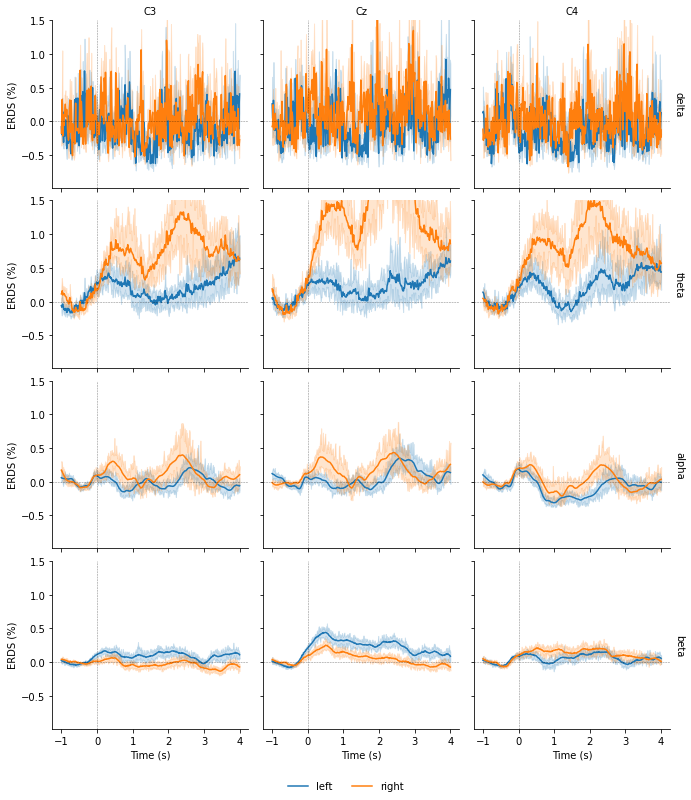

In [24]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Having the data as a DataFrame also facilitates subsetting,
grouping, and other transforms.
Here, we use seaborn to plot the average ERDS in the motor imagery interval
as a function of frequency band and imagery condition:



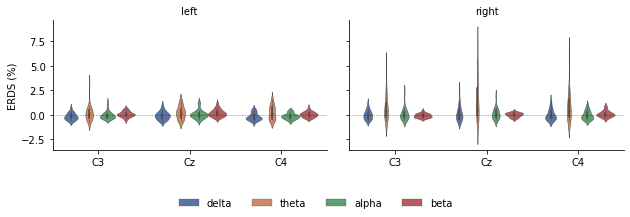

In [26]:
df_mean = (df.query('time > 1')
             .groupby(['condition', 'epoch', 'band', 'channel'])[['value']]
             .mean()
             .reset_index())

g = sns.FacetGrid(df_mean, col='condition', col_order=['left', 'right'],
                  margin_titles=True)
g = (g.map(sns.violinplot, 'channel', 'value', 'band', n_boot=10,
           palette='deep', order=['C3', 'Cz', 'C4'],
           hue_order=freq_bands_of_interest,
           linewidth=0.5).add_legend(ncol=4, loc='lower center'))

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

## References
.. footbibliography::

